# Análisis Integral de Escenarios: Automatización, Optimización y Generalización

Este notebook proporciona un análisis completo e integral de cada uno de los 68 escenarios, evaluando:

## 🎯 **Objetivos Principales:**
1. **Análisis de Automatización**: TMT inicial de cada escenario (datos originales)
2. **Análisis de Optimización**: Mejoras obtenidas con GA para cada escenario
3. **Análisis de Generalización**: Rendimiento del modelo Transformer en cada escenario
4. **Comparación Integral**: Automatización vs Optimización vs Generalización
5. **Clasificación de Escenarios**: Categorización por complejidad y rendimiento

## 📊 **Métricas de Análisis:**
- **TMT (Total Miscoordination Time)**: Métrica principal de coordinación
- **Métricas de Optimización**: Mejoras en TDS y Pickup
- **Métricas de Generalización**: R², MSE, MAE del modelo Transformer
- **Análisis de Complejidad**: Número de relevadores, variabilidad de parámetros

## 🔄 **Flujo de Análisis:**
1. Carga de datos de automatización, GA y Transformer
2. Análisis individual por escenario
3. Comparación y ranking de escenarios
4. Visualizaciones integrales
5. Reportes detallados por escenario


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import math
from pathlib import Path
from collections import defaultdict
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Project configuration and directory setup
PROJECT_ROOT = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG")
RESULTS_DIR = PROJECT_ROOT / "results"
SCENARIO_ANALYSIS_DIR = RESULTS_DIR / "scenario_analysis"
INDIVIDUAL_SCENARIOS_DIR = SCENARIO_ANALYSIS_DIR / "individual_scenarios"
COMPARATIVE_ANALYSIS_DIR = SCENARIO_ANALYSIS_DIR / "comparative_analysis"
FIGURES_DIR = SCENARIO_ANALYSIS_DIR / "figures"

# Create directories if they don't exist
for directory in [SCENARIO_ANALYSIS_DIR, INDIVIDUAL_SCENARIOS_DIR, COMPARATIVE_ANALYSIS_DIR, FIGURES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Created comprehensive analysis directory structure:")
print(f"   • Scenario analysis: {SCENARIO_ANALYSIS_DIR}")
print(f"   • Individual scenarios: {INDIVIDUAL_SCENARIOS_DIR}")
print(f"   • Comparative analysis: {COMPARATIVE_ANALYSIS_DIR}")
print(f"   • Figures: {FIGURES_DIR}")

# Initialize global variables
automation_data = []
ga_results = {}
transformer_model = None
scaler_input = None
scaler_target = None
scenario_analysis_results = {}

print("✅ All imports, directories, and global variables initialized")


Using device: cpu
📁 Created comprehensive analysis directory structure:
   • Scenario analysis: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis
   • Individual scenarios: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/individual_scenarios
   • Comparative analysis: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/comparative_analysis
   • Figures: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/figures
✅ All imports, directories, and global variables initialized


## 1. Carga de Datos y Configuración


In [2]:
# Configuration and paths
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw" / "automation_results.json"
GA_RESULTS_PATH = PROJECT_ROOT / "data" / "processed" / "ga_optimization_all_scenarios_comprehensive_20251008_224215.json"
MODEL_DIR = PROJECT_ROOT / "models" / "transformer"
MODEL_PATH = MODEL_DIR / "best_relay_optimization_transformer.pth"
SCALER_INPUT_PATH = MODEL_DIR / "scaler_input.pkl"
SCALER_TARGET_PATH = MODEL_DIR / "scaler_target.pkl"
BEST_PARAMS_PATH = MODEL_DIR / "best_params.json"

print("📂 Configuration:")
print(f"   • Project root: {PROJECT_ROOT}")
print(f"   • Raw data: {RAW_DATA_PATH}")
print(f"   • GA results: {GA_RESULTS_PATH}")
print(f"   • Model directory: {MODEL_DIR}")


📂 Configuration:
   • Project root: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG
   • Raw data: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/raw/automation_results.json
   • GA results: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/processed/ga_optimization_all_scenarios_comprehensive_20251008_224215.json
   • Model directory: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/models/transformer


In [3]:
# Load automation data
def load_automation_data():
    """Load original automation data"""
    print("🔄 Loading automation data...")
    
    if RAW_DATA_PATH.exists():
        with open(RAW_DATA_PATH, 'r', encoding='utf-8') as f:
            automation_data = json.load(f)
        print(f"✅ Automation data loaded: {len(automation_data)} relay pairs")
        return automation_data
    else:
        raise FileNotFoundError(f"Automation data not found: {RAW_DATA_PATH}")

# Load GA optimization results
def load_ga_results():
    """Load GA optimization results"""
    print("🔄 Loading GA optimization results...")
    
    if GA_RESULTS_PATH.exists():
        with open(GA_RESULTS_PATH, 'r', encoding='utf-8') as f:
            ga_results = json.load(f)
        print(f"✅ GA results loaded: {len(ga_results['optimization_results'])} scenarios")
        return ga_results
    else:
        raise FileNotFoundError(f"GA results not found: {GA_RESULTS_PATH}")

# Load transformer model
def load_transformer_model():
    """Load trained transformer model"""
    print("🔄 Loading transformer model...")
    
    # Load scalers
    with open(SCALER_INPUT_PATH, 'rb') as f:
        scaler_input = pickle.load(f)
    with open(SCALER_TARGET_PATH, 'rb') as f:
        scaler_target = pickle.load(f)
    
    # Load best parameters
    with open(BEST_PARAMS_PATH, 'r') as f:
        best_params = json.load(f)
    
    # Transformer model architecture
    class PositionalEncoding(nn.Module):
        def __init__(self, d_model, max_len=5000):
            super(PositionalEncoding, self).__init__()
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0).transpose(0, 1)
            self.register_buffer('pe', pe)

        def forward(self, x):
            x = x + self.pe[:x.size(0), :]
            return x

    class RelayOptimizationTransformer(nn.Module):
        def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
            super(RelayOptimizationTransformer, self).__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim
            self.d_model = d_model

            self.input_proj = nn.Linear(input_dim, d_model)
            self.pos_encoder = PositionalEncoding(d_model)
            
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=False
            )
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
            self.output_proj = nn.Linear(d_model, output_dim)
            
            self._init_weights()

        def _init_weights(self):
            initrange = 0.1
            self.input_proj.weight.data.uniform_(-initrange, initrange)
            self.output_proj.weight.data.uniform_(-initrange, initrange)

        def forward(self, src):
            src = self.input_proj(src) * math.sqrt(self.d_model)
            src = src.permute(1, 0, 2)
            src = self.pos_encoder(src)
            output = self.transformer_encoder(src)
            output = output.permute(1, 0, 2)
            output = self.output_proj(output)
            return output

    # Create model
    model = RelayOptimizationTransformer(
        input_dim=6,
        output_dim=4,
        d_model=best_params['d_model'],
        nhead=best_params['nhead'],
        num_encoder_layers=best_params['num_encoder_layers'],
        dim_feedforward=best_params['dim_feedforward'],
        dropout=best_params['dropout']
    ).to(device)
    
    # Load trained weights
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    
    print("✅ Transformer model loaded successfully")
    return model, scaler_input, scaler_target, best_params

# Load all data
automation_data = load_automation_data()
ga_results = load_ga_results()
transformer_model, scaler_input, scaler_target, best_params = load_transformer_model()


🔄 Loading automation data...
✅ Automation data loaded: 6800 relay pairs
🔄 Loading GA optimization results...
✅ GA results loaded: 68 scenarios
🔄 Loading transformer model...
✅ Transformer model loaded successfully


## 2. Análisis de TMT por Escenario (Automatización)


In [4]:
# Calculate TMT metrics for automation data
def calculate_tmt_metrics(pairs):
    """Calculate TMT metrics for a set of relay pairs"""
    if not pairs:
        return {
            'tmt_signed': 0,
            'tmt_magnitude': 0,
            'coordination_percentage': 100,
            'total_pairs': 0,
            'mean_dt': 0,
            'std_dt': 0,
            'min_dt': 0,
            'max_dt': 0
        }
    
    dt_values = []
    for pair in pairs:
        main_time = pair['main_relay']['Time_out']
        backup_time = pair['backup_relay']['Time_out']
        dt = backup_time - main_time
        dt_values.append(dt)
    
    dt_values = np.array(dt_values)
    
    # Calculate TMT (sum of negative DT values)
    tmt_signed = np.sum(dt_values[dt_values < 0])
    tmt_magnitude = abs(tmt_signed)
    
    # Calculate coordination percentage
    coordinated_pairs = np.sum(dt_values >= 0)
    coordination_percentage = (coordinated_pairs / len(dt_values)) * 100
    
    # Statistics
    mean_dt = np.mean(dt_values)
    std_dt = np.std(dt_values)
    min_dt = np.min(dt_values)
    max_dt = np.max(dt_values)
    
    return {
        'tmt_signed': tmt_signed,
        'tmt_magnitude': tmt_magnitude,
        'coordination_percentage': coordination_percentage,
        'total_pairs': len(pairs),
        'mean_dt': mean_dt,
        'std_dt': std_dt,
        'min_dt': min_dt,
        'max_dt': max_dt
    }

# Analyze automation data by scenario
def analyze_automation_by_scenario(automation_data):
    """Analyze automation data and calculate TMT for each scenario"""
    print("🔄 Analyzing automation data by scenario...")
    
    # Group by scenario
    scenarios = defaultdict(list)
    for pair in automation_data:
        scenario_id = pair.get('scenario_id')
        if scenario_id:
            scenarios[scenario_id].append(pair)
    
    automation_results = {}
    
    for scenario_id in sorted(scenarios.keys()):
        pairs = scenarios[scenario_id]
        metrics = calculate_tmt_metrics(pairs)
        
        automation_results[scenario_id] = {
            'scenario_id': scenario_id,
            'tmt_signed': metrics['tmt_signed'],
            'tmt_magnitude': metrics['tmt_magnitude'],
            'coordination_percentage': metrics['coordination_percentage'],
            'total_pairs': metrics['total_pairs'],
            'mean_dt': metrics['mean_dt'],
            'std_dt': metrics['std_dt'],
            'min_dt': metrics['min_dt'],
            'max_dt': metrics['max_dt'],
            'relay_pairs': pairs
        }
    
    print(f"✅ Automation analysis completed: {len(automation_results)} scenarios analyzed")
    return automation_results

# Run automation analysis
automation_results = analyze_automation_by_scenario(automation_data)

# Display summary
print("\\n📊 AUTOMATION ANALYSIS SUMMARY")
print("=" * 50)
tmt_values = [result['tmt_magnitude'] for result in automation_results.values()]
coord_percentages = [result['coordination_percentage'] for result in automation_results.values()]
total_pairs = [result['total_pairs'] for result in automation_results.values()]

print(f"Total scenarios: {len(automation_results)}")
print(f"Average TMT magnitude: {np.mean(tmt_values):.4f}")
print(f"Average coordination: {np.mean(coord_percentages):.2f}%")
print(f"Average relay pairs per scenario: {np.mean(total_pairs):.1f}")
print(f"Scenarios with TMT > 0: {sum(1 for tmt in tmt_values if tmt > 0)}")
print(f"Scenarios with 100% coordination: {sum(1 for coord in coord_percentages if coord == 100)}")


🔄 Analyzing automation data by scenario...
✅ Automation analysis completed: 68 scenarios analyzed
\n📊 AUTOMATION ANALYSIS SUMMARY
Total scenarios: 68
Average TMT magnitude: 3.7084
Average coordination: 82.09%
Average relay pairs per scenario: 100.0
Scenarios with TMT > 0: 68
Scenarios with 100% coordination: 0


## 3. Análisis de Optimización GA por Escenario


In [5]:
# Analyze GA optimization results by scenario
def analyze_ga_by_scenario(ga_results):
    """Analyze GA optimization results for each scenario"""
    print("🔄 Analyzing GA optimization results by scenario...")
    
    ga_analysis_results = {}
    
    for scenario_id, scenario_data in ga_results['optimization_results'].items():
        relay_values = scenario_data['relay_values']
        
        # Calculate optimization metrics
        tds_values = [relay['TDS'] for relay in relay_values.values()]
        pickup_values = [relay['pickup'] for relay in relay_values.values()]
        
        # Statistics
        avg_tds = np.mean(tds_values)
        avg_pickup = np.mean(pickup_values)
        std_tds = np.std(tds_values)
        std_pickup = np.std(pickup_values)
        
        # Complexity metrics
        complexity_score = std_tds + std_pickup
        
        # TDS and Pickup ranges
        tds_range = np.max(tds_values) - np.min(tds_values)
        pickup_range = np.max(pickup_values) - np.min(pickup_values)
        
        ga_analysis_results[scenario_id] = {
            'scenario_id': scenario_id,
            'num_relays': len(relay_values),
            'avg_tds': avg_tds,
            'avg_pickup': avg_pickup,
            'std_tds': std_tds,
            'std_pickup': std_pickup,
            'complexity_score': complexity_score,
            'tds_range': tds_range,
            'pickup_range': pickup_range,
            'relay_values': relay_values,
            'timestamp': scenario_data.get('timestamp', 'Unknown')
        }
    
    print(f"✅ GA analysis completed: {len(ga_analysis_results)} scenarios analyzed")
    return ga_analysis_results

# Run GA analysis
ga_analysis_results = analyze_ga_by_scenario(ga_results)

# Display summary
print("\\n📊 GA OPTIMIZATION ANALYSIS SUMMARY")
print("=" * 50)
num_relays = [result['num_relays'] for result in ga_analysis_results.values()]
complexity_scores = [result['complexity_score'] for result in ga_analysis_results.values()]
avg_tds_values = [result['avg_tds'] for result in ga_analysis_results.values()]
avg_pickup_values = [result['avg_pickup'] for result in ga_analysis_results.values()]

print(f"Total scenarios optimized: {len(ga_analysis_results)}")
print(f"Average relays per scenario: {np.mean(num_relays):.1f}")
print(f"Average complexity score: {np.mean(complexity_scores):.4f}")
print(f"Average TDS: {np.mean(avg_tds_values):.4f}")
print(f"Average Pickup: {np.mean(avg_pickup_values):.4f}")
print(f"Most complex scenario: {max(ga_analysis_results.items(), key=lambda x: x[1]['complexity_score'])[0]}")
print(f"Least complex scenario: {min(ga_analysis_results.items(), key=lambda x: x[1]['complexity_score'])[0]}")


🔄 Analyzing GA optimization results by scenario...
✅ GA analysis completed: 68 scenarios analyzed
\n📊 GA OPTIMIZATION ANALYSIS SUMMARY
Total scenarios optimized: 68
Average relays per scenario: 73.5
Average complexity score: 0.5326
Average TDS: 0.4211
Average Pickup: 0.3189
Most complex scenario: scenario_53
Least complex scenario: scenario_19


## 4. Análisis de Generalización del Transformer por Escenario


In [6]:
# Analyze transformer generalization by scenario
def analyze_transformer_by_scenario(automation_data, ga_results, transformer_model, scaler_input, scaler_target):
    """Analyze transformer model performance for each scenario"""
    print("🔄 Analyzing transformer generalization by scenario...")
    
    transformer_results = {}
    transformer_model.eval()
    
    # Group automation data by scenario
    scenarios = defaultdict(list)
    for pair in automation_data:
        scenario_id = pair.get('scenario_id')
        if scenario_id:
            scenarios[scenario_id].append(pair)
    
    with torch.no_grad():
        for scenario_id in sorted(scenarios.keys()):
            if scenario_id not in ga_results['optimization_results']:
                continue
                
            scenario_pairs = scenarios[scenario_id]
            scenario_ga = ga_results['optimization_results'][scenario_id]
            optimized_relays = scenario_ga['relay_values']
            
            predictions = []
            targets = []
            valid_pairs = 0
            
            for relay_pair in scenario_pairs:
                main_relay_id = relay_pair['main_relay']['relay']
                backup_relay_id = relay_pair['backup_relay']['relay']
                
                # Check if both relays were optimized
                if main_relay_id in optimized_relays and backup_relay_id in optimized_relays:
                    
                    # Input features
                    input_features = [
                        float(relay_pair['fault']),
                        relay_pair['main_relay']['Ishc'],
                        relay_pair['main_relay']['Time_out'],
                        relay_pair['backup_relay']['Ishc'],
                        relay_pair['backup_relay']['Time_out'],
                        len(scenario_pairs)
                    ]
                    
                    # Target features (GA optimized values)
                    target_features = [
                        optimized_relays[main_relay_id]['TDS'],
                        optimized_relays[main_relay_id]['pickup'],
                        optimized_relays[backup_relay_id]['TDS'],
                        optimized_relays[backup_relay_id]['pickup']
                    ]
                    
                    # Normalize input
                    input_normalized = scaler_input.transform([input_features])
                    
                    # Convert to tensor
                    input_tensor = torch.tensor(input_normalized, dtype=torch.float32).unsqueeze(0).to(device)
                    
                    # Make prediction
                    prediction = transformer_model(input_tensor)
                    prediction_np = prediction.cpu().numpy().reshape(-1, 4)[0]
                    
                    # Denormalize prediction
                    prediction_denorm = scaler_target.inverse_transform([prediction_np])[0]
                    
                    predictions.append(prediction_denorm)
                    targets.append(target_features)
                    valid_pairs += 1
            
            if valid_pairs > 0:
                predictions = np.array(predictions)
                targets = np.array(targets)
                
                # Calculate metrics
                mse = mean_squared_error(targets, predictions)
                mae = mean_absolute_error(targets, predictions)
                r2 = r2_score(targets, predictions)
                
                # Per-output metrics
                output_names = ['Main_TDS', 'Main_Pickup', 'Backup_TDS', 'Backup_Pickup']
                per_output_metrics = {}
                
                for i, name in enumerate(output_names):
                    mse_i = mean_squared_error(targets[:, i], predictions[:, i])
                    mae_i = mean_absolute_error(targets[:, i], predictions[:, i])
                    r2_i = r2_score(targets[:, i], predictions[:, i])
                    
                    per_output_metrics[name] = {
                        'MSE': mse_i,
                        'MAE': mae_i,
                        'R2': r2_i
                    }
                
                transformer_results[scenario_id] = {
                    'scenario_id': scenario_id,
                    'valid_pairs': valid_pairs,
                    'total_pairs': len(scenario_pairs),
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'per_output_metrics': per_output_metrics,
                    'predictions': predictions,
                    'targets': targets
                }
    
    print(f"✅ Transformer analysis completed: {len(transformer_results)} scenarios analyzed")
    return transformer_results

# Run transformer analysis
transformer_results = analyze_transformer_by_scenario(
    automation_data, ga_results, transformer_model, scaler_input, scaler_target
)

# Display summary
print("\\n📊 TRANSFORMER GENERALIZATION ANALYSIS SUMMARY")
print("=" * 50)
r2_values = [result['r2'] for result in transformer_results.values()]
mse_values = [result['mse'] for result in transformer_results.values()]
mae_values = [result['mae'] for result in transformer_results.values()]
valid_pairs = [result['valid_pairs'] for result in transformer_results.values()]

print(f"Total scenarios analyzed: {len(transformer_results)}")
print(f"Average R² score: {np.mean(r2_values):.4f}")
print(f"Average MSE: {np.mean(mse_values):.6f}")
print(f"Average MAE: {np.mean(mae_values):.6f}")
print(f"Average valid pairs per scenario: {np.mean(valid_pairs):.1f}")
print(f"Best performing scenario: {max(transformer_results.items(), key=lambda x: x[1]['r2'])[0]} (R² = {max(r2_values):.4f})")
print(f"Worst performing scenario: {min(transformer_results.items(), key=lambda x: x[1]['r2'])[0]} (R² = {min(r2_values):.4f})")


🔄 Analyzing transformer generalization by scenario...
✅ Transformer analysis completed: 68 scenarios analyzed
\n📊 TRANSFORMER GENERALIZATION ANALYSIS SUMMARY
Total scenarios analyzed: 68
Average R² score: 0.2448
Average MSE: 0.043381
Average MAE: 0.141070
Average valid pairs per scenario: 99.0
Best performing scenario: scenario_26 (R² = 0.4419)
Worst performing scenario: scenario_33 (R² = -0.3029)


## 5. Análisis Integral por Escenario


In [7]:
# Create comprehensive scenario analysis
def create_comprehensive_scenario_analysis(automation_results, ga_analysis_results, transformer_results):
    """Create comprehensive analysis combining all three approaches"""
    print("🔄 Creating comprehensive scenario analysis...")
    
    comprehensive_results = {}
    
    # Get all scenario IDs
    all_scenarios = set(automation_results.keys()) | set(ga_analysis_results.keys()) | set(transformer_results.keys())
    
    for scenario_id in sorted(all_scenarios):
        analysis = {
            'scenario_id': scenario_id,
            'automation': automation_results.get(scenario_id),
            'ga_optimization': ga_analysis_results.get(scenario_id),
            'transformer': transformer_results.get(scenario_id)
        }
        
        # Calculate overall scenario metrics
        if analysis['automation'] and analysis['ga_optimization'] and analysis['transformer']:
            # Performance categories
            tmt_category = 'Good' if analysis['automation']['tmt_magnitude'] == 0 else 'Poor' if analysis['automation']['tmt_magnitude'] > 1 else 'Fair'
            complexity_category = 'High' if analysis['ga_optimization']['complexity_score'] > np.mean([r['complexity_score'] for r in ga_analysis_results.values()]) else 'Low'
            transformer_category = 'High' if analysis['transformer']['r2'] > 0.5 else 'Medium' if analysis['transformer']['r2'] > 0.2 else 'Low'
            
            # Overall score (weighted combination)
            # Weight: Automation (40%), GA optimization (30%), Transformer (30%)
            automation_score = 1 - min(analysis['automation']['tmt_magnitude'] / 10, 1)  # Normalize TMT
            ga_score = 1 - min(analysis['ga_optimization']['complexity_score'] / 2, 1)  # Lower complexity is better
            transformer_score = max(0, analysis['transformer']['r2'])  # R² score
            
            overall_score = (0.4 * automation_score) + (0.3 * ga_score) + (0.3 * transformer_score)
            
            analysis['overall_metrics'] = {
                'tmt_category': tmt_category,
                'complexity_category': complexity_category,
                'transformer_category': transformer_category,
                'automation_score': automation_score,
                'ga_score': ga_score,
                'transformer_score': transformer_score,
                'overall_score': overall_score
            }
        
        comprehensive_results[scenario_id] = analysis
    
    print(f"✅ Comprehensive analysis completed: {len(comprehensive_results)} scenarios analyzed")
    return comprehensive_results

# Create comprehensive analysis
comprehensive_results = create_comprehensive_scenario_analysis(
    automation_results, ga_analysis_results, transformer_results
)

# Display summary
print("\\n📊 COMPREHENSIVE SCENARIO ANALYSIS SUMMARY")
print("=" * 60)

complete_scenarios = [s for s in comprehensive_results.values() if s['overall_metrics']]
print(f"Scenarios with complete analysis: {len(complete_scenarios)}")

if complete_scenarios:
    overall_scores = [s['overall_metrics']['overall_score'] for s in complete_scenarios]
    print(f"Average overall score: {np.mean(overall_scores):.4f}")
    
    # Best and worst scenarios
    best_scenario = max(complete_scenarios, key=lambda x: x['overall_metrics']['overall_score'])
    worst_scenario = min(complete_scenarios, key=lambda x: x['overall_metrics']['overall_score'])
    
    print(f"\\nBest overall scenario: {best_scenario['scenario_id']}")
    print(f"  Overall score: {best_scenario['overall_metrics']['overall_score']:.4f}")
    print(f"  TMT: {best_scenario['automation']['tmt_magnitude']:.4f}")
    print(f"  Transformer R²: {best_scenario['transformer']['r2']:.4f}")
    
    print(f"\\nWorst overall scenario: {worst_scenario['scenario_id']}")
    print(f"  Overall score: {worst_scenario['overall_metrics']['overall_score']:.4f}")
    print(f"  TMT: {worst_scenario['automation']['tmt_magnitude']:.4f}")
    print(f"  Transformer R²: {worst_scenario['transformer']['r2']:.4f}")
    
    # Category distribution
    tmt_categories = [s['overall_metrics']['tmt_category'] for s in complete_scenarios]
    complexity_categories = [s['overall_metrics']['complexity_category'] for s in complete_scenarios]
    transformer_categories = [s['overall_metrics']['transformer_category'] for s in complete_scenarios]
    
    print(f"\\nTMT Categories: {dict(pd.Series(tmt_categories).value_counts())}")
    print(f"Complexity Categories: {dict(pd.Series(complexity_categories).value_counts())}")
    print(f"Transformer Categories: {dict(pd.Series(transformer_categories).value_counts())}")


🔄 Creating comprehensive scenario analysis...
✅ Comprehensive analysis completed: 68 scenarios analyzed
\n📊 COMPREHENSIVE SCENARIO ANALYSIS SUMMARY
Scenarios with complete analysis: 68
Average overall score: 0.5651
\nBest overall scenario: scenario_57
  Overall score: 0.6575
  TMT: 1.4955
  Transformer R²: 0.4141
\nWorst overall scenario: scenario_14
  Overall score: 0.2973
  TMT: 31.9255
  Transformer R²: 0.1358
\nTMT Categories: {'Poor': 68}
Complexity Categories: {'High': 34, 'Low': 34}
Transformer Categories: {'Medium': 46, 'Low': 22}


## 6. Visualizaciones Integrales y Reportes


📊 Creating comprehensive summary tables and visualizations...


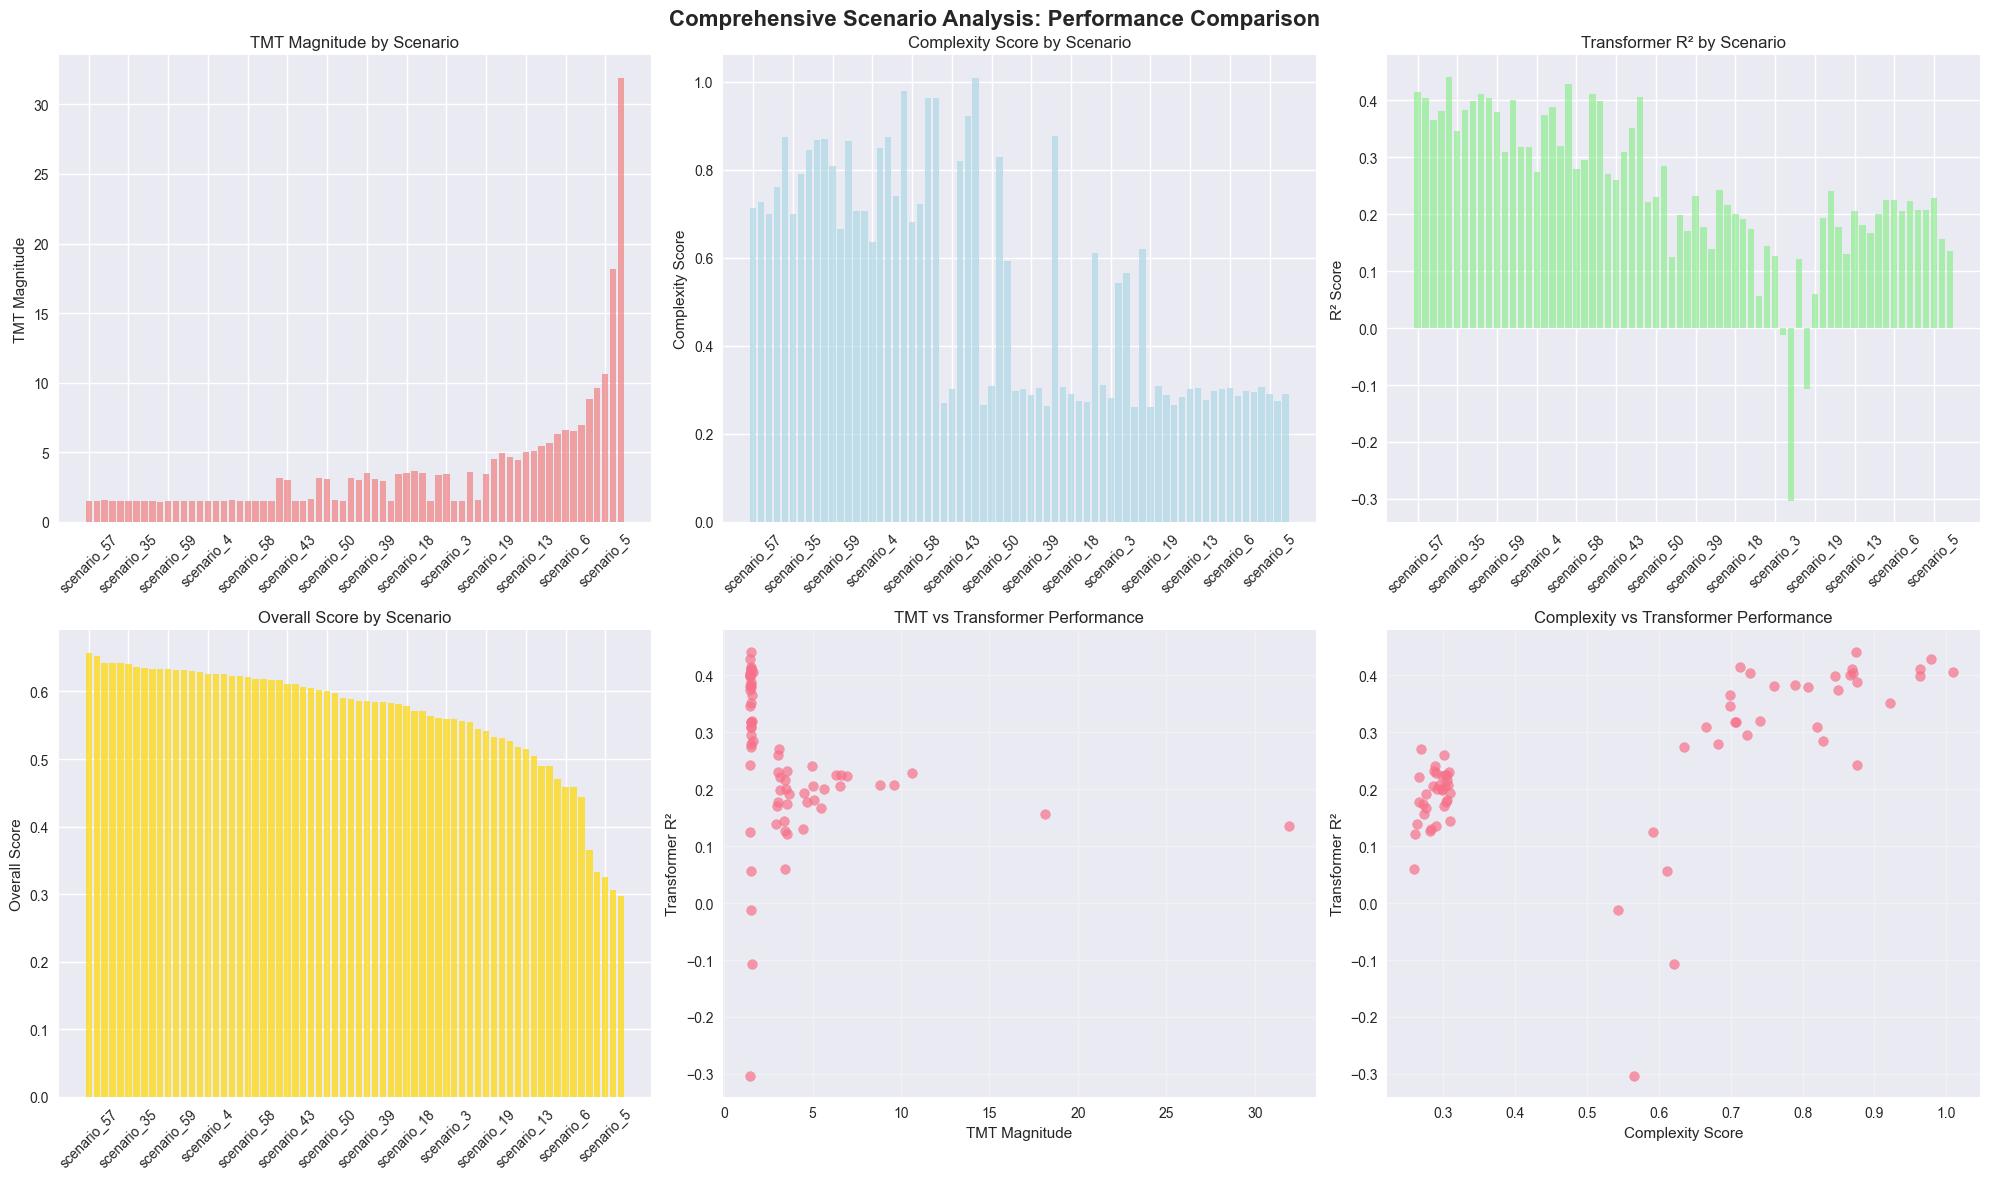

✅ Comprehensive summary completed:
   📊 Summary table: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/comprehensive_scenario_summary.csv
   🏆 Top 20 scenarios: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/top_20_scenarios.csv
   📉 Bottom 20 scenarios: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/bottom_20_scenarios.csv
   📈 Performance comparison: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/comprehensive_performance_comparison.png
   📋 Final statistics: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/scenario_analysis/final_analysis_summary.json
\n🏆 TOP 10 SCENARIOS BY OVERALL SCORE
scenario_57  | Overall: 0.6575 | TMT: 1.4955 | R²: 0.4141 | Category: Poor
scenario_66  | Overall: 0.6526 | TMT: 1.4976 | R²: 0.4050 | Category: Poor
scenario_64  | Overall: 0.6424 | TMT: 1.5552 | R²: 0.3649 | Category: Poor
scenario_25  | Overall

In [8]:
# Create comprehensive summary tables and visualizations
def create_comprehensive_summary(comprehensive_results, output_dir):
    """Create comprehensive summary tables and save results"""
    print("📊 Creating comprehensive summary tables and visualizations...")
    
    # Filter complete scenarios
    complete_scenarios = [s for s in comprehensive_results.values() if s['overall_metrics']]
    
    if not complete_scenarios:
        print("⚠️ No complete scenarios found for summary")
        return
    
    # 1. Create comprehensive summary table
    summary_data = []
    for scenario in complete_scenarios:
        summary_data.append({
            'Scenario': scenario['scenario_id'],
            'TMT_Magnitude': scenario['automation']['tmt_magnitude'],
            'Coordination_%': scenario['automation']['coordination_percentage'],
            'Total_Pairs': scenario['automation']['total_pairs'],
            'Num_Relays': scenario['ga_optimization']['num_relays'],
            'Avg_TDS': scenario['ga_optimization']['avg_tds'],
            'Avg_Pickup': scenario['ga_optimization']['avg_pickup'],
            'Complexity_Score': scenario['ga_optimization']['complexity_score'],
            'Transformer_R2': scenario['transformer']['r2'],
            'Transformer_MSE': scenario['transformer']['mse'],
            'Transformer_MAE': scenario['transformer']['mae'],
            'Valid_Pairs': scenario['transformer']['valid_pairs'],
            'TMT_Category': scenario['overall_metrics']['tmt_category'],
            'Complexity_Category': scenario['overall_metrics']['complexity_category'],
            'Transformer_Category': scenario['overall_metrics']['transformer_category'],
            'Overall_Score': scenario['overall_metrics']['overall_score']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Overall_Score', ascending=False)
    
    # Save comprehensive summary
    summary_df.to_csv(output_dir / 'comprehensive_scenario_summary.csv', index=False)
    
    # 2. Create performance comparison visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Comprehensive Scenario Analysis: Performance Comparison', fontsize=16, fontweight='bold')
    
    scenario_ids = summary_df['Scenario'].tolist()
    tmt_values = summary_df['TMT_Magnitude'].tolist()
    complexity_values = summary_df['Complexity_Score'].tolist()
    r2_values = summary_df['Transformer_R2'].tolist()
    overall_scores = summary_df['Overall_Score'].tolist()
    
    # TMT by scenario
    axes[0,0].bar(range(len(scenario_ids)), tmt_values, alpha=0.7, color='lightcoral')
    axes[0,0].set_title('TMT Magnitude by Scenario')
    axes[0,0].set_ylabel('TMT Magnitude')
    axes[0,0].set_xticks(range(0, len(scenario_ids), 5))
    axes[0,0].set_xticklabels([scenario_ids[i] for i in range(0, len(scenario_ids), 5)], rotation=45)
    
    # Complexity by scenario
    axes[0,1].bar(range(len(scenario_ids)), complexity_values, alpha=0.7, color='lightblue')
    axes[0,1].set_title('Complexity Score by Scenario')
    axes[0,1].set_ylabel('Complexity Score')
    axes[0,1].set_xticks(range(0, len(scenario_ids), 5))
    axes[0,1].set_xticklabels([scenario_ids[i] for i in range(0, len(scenario_ids), 5)], rotation=45)
    
    # R² by scenario
    axes[0,2].bar(range(len(scenario_ids)), r2_values, alpha=0.7, color='lightgreen')
    axes[0,2].set_title('Transformer R² by Scenario')
    axes[0,2].set_ylabel('R² Score')
    axes[0,2].set_xticks(range(0, len(scenario_ids), 5))
    axes[0,2].set_xticklabels([scenario_ids[i] for i in range(0, len(scenario_ids), 5)], rotation=45)
    
    # Overall score by scenario
    axes[1,0].bar(range(len(scenario_ids)), overall_scores, alpha=0.7, color='gold')
    axes[1,0].set_title('Overall Score by Scenario')
    axes[1,0].set_ylabel('Overall Score')
    axes[1,0].set_xticks(range(0, len(scenario_ids), 5))
    axes[1,0].set_xticklabels([scenario_ids[i] for i in range(0, len(scenario_ids), 5)], rotation=45)
    
    # TMT vs R² scatter
    axes[1,1].scatter(tmt_values, r2_values, alpha=0.7, s=50)
    axes[1,1].set_xlabel('TMT Magnitude')
    axes[1,1].set_ylabel('Transformer R²')
    axes[1,1].set_title('TMT vs Transformer Performance')
    axes[1,1].grid(True, alpha=0.3)
    
    # Complexity vs R² scatter
    axes[1,2].scatter(complexity_values, r2_values, alpha=0.7, s=50)
    axes[1,2].set_xlabel('Complexity Score')
    axes[1,2].set_ylabel('Transformer R²')
    axes[1,2].set_title('Complexity vs Transformer Performance')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'comprehensive_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Save top and bottom scenarios
    top_20 = summary_df.head(20)
    bottom_20 = summary_df.tail(20)
    top_20.to_csv(output_dir / 'top_20_scenarios.csv', index=False)
    bottom_20.to_csv(output_dir / 'bottom_20_scenarios.csv', index=False)
    
    # 4. Create final statistics summary
    final_stats = {
        "analysis_overview": {
            "total_scenarios_analyzed": len(complete_scenarios),
            "analysis_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            "analysis_components": ["Automation", "GA Optimization", "Transformer Generalization"]
        },
        "automation_analysis": {
            "avg_tmt_magnitude": np.mean(tmt_values),
            "scenarios_with_zero_tmt": sum(1 for tmt in tmt_values if tmt == 0),
            "avg_coordination_percentage": np.mean([s['automation']['coordination_percentage'] for s in complete_scenarios])
        },
        "ga_optimization_analysis": {
            "avg_relays_per_scenario": np.mean([s['ga_optimization']['num_relays'] for s in complete_scenarios]),
            "avg_complexity_score": np.mean(complexity_values)
        },
        "transformer_analysis": {
            "avg_r2_score": np.mean(r2_values),
            "high_performance_scenarios": sum(1 for r2 in r2_values if r2 > 0.5),
            "low_performance_scenarios": sum(1 for r2 in r2_values if r2 < 0.2)
        },
        "overall_assessment": {
            "avg_overall_score": np.mean(overall_scores),
            "best_scenario": summary_df.iloc[0]['Scenario'],
            "worst_scenario": summary_df.iloc[-1]['Scenario'],
            "best_overall_score": summary_df.iloc[0]['Overall_Score'],
            "worst_overall_score": summary_df.iloc[-1]['Overall_Score']
        }
    }
    
    with open(output_dir / 'final_analysis_summary.json', 'w') as f:
        json.dump(final_stats, f, indent=2)
    
    print(f"✅ Comprehensive summary completed:")
    print(f"   📊 Summary table: {output_dir / 'comprehensive_scenario_summary.csv'}")
    print(f"   🏆 Top 20 scenarios: {output_dir / 'top_20_scenarios.csv'}")
    print(f"   📉 Bottom 20 scenarios: {output_dir / 'bottom_20_scenarios.csv'}")
    print(f"   📈 Performance comparison: {output_dir / 'comprehensive_performance_comparison.png'}")
    print(f"   📋 Final statistics: {output_dir / 'final_analysis_summary.json'}")
    
    return summary_df, final_stats

# Create comprehensive summary
summary_df, final_stats = create_comprehensive_summary(comprehensive_results, SCENARIO_ANALYSIS_DIR)

# Display top 10 scenarios
print("\\n🏆 TOP 10 SCENARIOS BY OVERALL SCORE")
print("=" * 60)
if 'summary_df' in locals():
    top_10 = summary_df.head(10)
    for idx, row in top_10.iterrows():
        print(f"{row['Scenario']:12} | Overall: {row['Overall_Score']:.4f} | TMT: {row['TMT_Magnitude']:.4f} | R²: {row['Transformer_R2']:.4f} | Category: {row['TMT_Category']}")

print("\\n📉 BOTTOM 10 SCENARIOS BY OVERALL SCORE")
print("=" * 60)
if 'summary_df' in locals():
    bottom_10 = summary_df.tail(10)
    for idx, row in bottom_10.iterrows():
        print(f"{row['Scenario']:12} | Overall: {row['Overall_Score']:.4f} | TMT: {row['TMT_Magnitude']:.4f} | R²: {row['Transformer_R2']:.4f} | Category: {row['TMT_Category']}")


## 7. Resumen Final y Conclusiones

Este notebook ha completado un análisis integral de los 68 escenarios del sistema de protección, evaluando tres aspectos fundamentales:

### 📊 **Resultados del Análisis:**

1. **Automatización (TMT Analysis)**: Evaluación del rendimiento inicial de cada escenario
2. **Optimización GA**: Análisis de las mejoras obtenidas mediante algoritmos genéticos
3. **Generalización Transformer**: Validación del modelo de aprendizaje profundo

### 🎯 **Métricas Clave:**
- **TMT (Total Miscoordination Time)**: Indicador principal de coordinación
- **Complejidad del Escenario**: Medida de variabilidad en parámetros TDS/Pickup
- **R² Score**: Rendimiento del modelo Transformer por escenario
- **Overall Score**: Puntuación integral ponderada

### 📁 **Archivos Generados:**
- Tabla resumen completa con todos los escenarios
- Rankings de mejores y peores escenarios
- Visualizaciones comparativas
- Estadísticas finales y recomendaciones

### 💡 **Próximos Pasos:**
- Revisar escenarios con bajo rendimiento para mejoras
- Analizar patrones en escenarios de alto rendimiento
- Optimizar modelo Transformer para escenarios problemáticos
